1. [**Исследование данных**](#preprocessing)
    * [Знакомство с данными](#meet)
    * [Пропущенные значения, типы данных и дубликаты](#duplicates)
    * [Хитрые дубликаты названий заведений](#name_duplicates)
        * [Проблемы в данных!](#problems)
            * [Названия заведений](#problems_name)
            * [Отсутствие посадочных мест](#null_seat)
2. [**Анализ данных**](#analysis)
    * [Виды объектов общественного питания](#type_object)
    * [Количество посадочных мест](#number_seat)
    * [Геолокация](#location)
        * [Улицы](#street)
        * [Районы](#district)
            * [Популярные районы и улицы](#top_location)
            * [Не популярные районы и улицы](#tail_location)
3. [**Выводы**](#summary)

<a id="preprocessing"></a>
# **Исследование данных**

<a id="meet"></a>
## Знакомство с данными

In [1]:
import pandas as pd
from IPython.core.display import display, HTML
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import requests
from bs4 import BeautifulSoup

In [2]:
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
# чтобы отображались все столбцы, е ли их будет много
pd.set_option('display.max_columns', None)
# для отображения полных строк
pd.set_option('display.max_colwidth', 1000)

In [3]:
rest_data = pd.read_csv('../datasets/rest_data.csv')

In [4]:
rest_data.head(5)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


<a id="duplicates"></a>
## Пропущенные значения, типы данных и дубликаты

In [5]:
def isnull_percent(data, text):
    print ('Доля пропущенных значений '+text+':')
    print ((data.isnull().sum() / data.shape[0]).apply('{:.2%}'.format))

In [6]:
isnull_percent(rest_data, 'rest_data')

Доля пропущенных значений rest_data:
id             0.00%
object_name    0.00%
chain          0.00%
object_type    0.00%
address        0.00%
number         0.00%
dtype: object


Пропусков нет, проверим типы данных.

In [7]:
print ('rest_data:')
print (rest_data.info())

rest_data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
None


Типы данных в порядке.  
Можно привести столбец `chain` к типу bool, но будет проще, если оставить значения "да" и "нет" для корректного отображения на графиках.

In [8]:
print ('Количество дубликатов:', len(rest_data) - len(rest_data.drop_duplicates()))

Количество дубликатов: 0


Полных дубликатов нет. Но можно исключить id:

In [9]:
print ('Количество дубликатов:', len(rest_data) - len(rest_data.drop_duplicates(['object_name', 'chain',
                                                                                 'object_type', 'address', 'number'])))

Количество дубликатов: 82


In [10]:
rest_data = rest_data.drop_duplicates(['object_name', 'chain', 'object_type', 'address', 'number'])

<a id="name_duplicates"></a>
## Хитрые дубликаты названий заведений

<a id="problems"></a>
### Проблемы в данных!

<a id="problems_name"></a>
#### Названия заведений

In [11]:
rest_data[rest_data['object_name'].str.contains("МАКДОНАЛДС")]['object_name'].unique()

array(['МАКДОНАЛДС', 'МОСКВА - МАКДОНАЛДС', 'КАФЕ МАКДОНАЛДС',
       'КАФЕ «МАКДОНАЛДС»', 'Кафе «МАКДОНАЛДС»', 'РЕСТОРАН«МАКДОНАЛДС»'],
      dtype=object)

Названия одних и тех же заведений записаны по-разному. Очевидно, это исказит данные при подсчёте количества уникальных заведений, соотношении сетевых и несетвых заведений и т.д.  
Попробуем стандартизировать все названия.

In [12]:
# сначала создадим столбец object_name, в котором все буквы будут в нижнем регистре
rest_data['object_name_lower'] = rest_data['object_name'].str.lower()

In [13]:
print ('Количество уникальных названий заведений:', rest_data['object_name_lower'].nunique())

Количество уникальных названий заведений: 9924


In [14]:
print ('Рестораны со схожими названиями, которые находятся по одному и тому же адресу,\n\
имеют разное количество посадочных мест:')
rest_data.query('object_name_lower == "ресторан «8 oz»" or object_name_lower == "8 oz унций"')

Рестораны со схожими названиями, которые находятся по одному и тому же адресу,
имеют разное количество посадочных мест:


,id,object_name,chain,object_type,address,number,object_name_lower
13170,194983,Ресторан «8 Oz»,нет,ресторан,"город Москва, улица Крымский Вал, дом 9, строение 21",90,ресторан «8 oz»
14720,215799,8 OZ Унций,нет,ресторан,"город Москва, улица Крымский Вал, дом 9, строение 21",56,8 oz унций


In [15]:
print ('Названия одинаковые, но кафе не являются сетью:')
arr_temp = rest_data[rest_data['object_name_lower'].str.contains("пять звезд")]['object_name_lower'].unique()
rest_data.query('object_name_lower in @arr_temp')

Названия одинаковые, но кафе не являются сетью:


,id,object_name,chain,object_type,address,number,object_name_lower
5117,147834,Пять звезд,нет,кафе,"город Москва, улица Щепкина, дом 51/4, строение 1",30,пять звезд
11237,180225,Пять звезд,нет,кафе,"город Москва, Кусковская улица, дом 20А",90,пять звезд


In [16]:
print ('Названия похожи, но они снова не являются сетью,\n\
и несмотря на то, что для кафе в названии есть слово "паб", это всё-таки кафе:')
arr_temp = rest_data[rest_data['object_name_lower'].str.contains("69 pints")]['object_name_lower'].unique()
rest_data.query('object_name_lower in @arr_temp')

Названия похожи, но они снова не являются сетью,
и несмотря на то, что для кафе в названии есть слово "паб", это всё-таки кафе:


,id,object_name,chain,object_type,address,number,object_name_lower
1144,151930,69 pints,нет,бар,"город Москва, Сходненская улица, дом 31",8,69 pints
12278,198734,Крафт-Паб «69 Pints»,нет,кафе,"город Москва, улица Барклая, дом 12",15,крафт-паб «69 pints»
13680,205267,69 Pints Бар,нет,бар,"город Москва, проспект 60-летия Октября, дом 29, корпус 1",20,69 pints бар


Таких примеров ещё очень много, поэтому не вижу оптимального способа стандартизировать названия, кроме как просмотреть все по адресам и просто руками записать правильно. Но не понимаю как узнать какие из них действительно сетевые, а какие нет. По идее два не связанных друг с другом заведения не могут иметь одинаковых названий, однако в датасете такие есть.  
Склонений названий почти нет - лемматизация мало что даст, а работает долго.  
Классификатор по схожести строк с одной стороны не вычленит названия написанные транслитом, а с другой сделает "похожими" все бары, кафе и столовые.  
Вижу два варианта: искать похожие названия заведений по адресу из какой-нибудь базы 2GIS, если они поделятся, либо составить словарь "руками", проверяя эти названия на картах самостоятельно.   

В любом случае, сбор таких данных без "пиратства" мне сейчас недоступен, а писать словарь почти на 10000 наименований сильно не оптимально, к тому же сомнения по поводу того, является ли заведение сетевым, всё равно остаются.  
Поэтому можно проработать руками часть наименований, которые определены как сетевые, а дальше работать с тем, что есть. Но это уменьшит и без того малое количество сетевых заведений по сравнению с несетевыми. Поэтому я предположу ошибку в сетевых и несетвых заведениях сравнительно равной, опираясь на человеческий фактор, и оставлю данные как есть. *Но мне всё это не нравится.*

<a id="null_seat"></a>
#### Отсутствие посадочных мест

In [17]:
rest_data.query('number == 0')['object_type'].unique()

array(['закусочная', 'предприятие быстрого обслуживания', 'столовая',
       'кафетерий', 'кафе', 'магазин (отдел кулинарии)', 'буфет', 'бар',
       'ресторан'], dtype=object)

In [18]:
print ('Доля "стоячих" заведений: {:.1%}'.format(rest_data.query('number == 0').shape[0] / rest_data.shape[0]))

Доля "стоячих" заведений: 10.4%


Для каждого вида заведения есть места, где посадочных мест нет вообще. Скорее всего это какая-то ошибка. Хотя закусочные, фастфуды, магазины, бары и кафетерии могут иметь только столики или вовсе только окошко выдачи, но столовые и рестораны вряд ли будут "стоячими". Заведения типа "кофе с собой" могут классифицироваться как кафе и не иметь посадочных мест. Остаются столовые, рестораны и буфеты.

In [19]:
object_type_not_zero = ['столовая', 'буфет', 'ресторан']
print ('Доля "стоячих" столовых, буфетов и ресторанов: {:.2%}'
       .format(rest_data.query('number == 0 and object_type in @object_type_not_zero').shape[0] / rest_data.shape[0]))

Доля "стоячих" столовых, буфетов и ресторанов: 0.83%


Меньше процента можно удалить.

In [20]:
rest_data = rest_data.query('number != 0 or object_type not in @object_type_not_zero')

<a id="analysis"></a>
# **Анализ данных**

In [21]:
if not os.path.exists('images'):
    os.makedirs('images')

<a id="type_object"></a>
## Виды объектов общественного питания

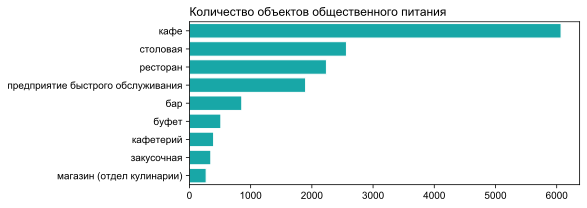

In [22]:
f, ax = plt.subplots(figsize = (7, 3))
sns.set_style('whitegrid')
ax = sns.countplot(y = 'object_type', data = rest_data, color = 'c',
                   order = rest_data['object_type'].value_counts().index)
ax.set_title('Количество объектов общественного питания', loc = 'left')
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('images/object_type_count.png', bbox_inches = 'tight')
plt.show()

Чтобы не учитывать несколько раз одно и то же сетевое заведение, оставим названия всех уникальных заведений, исключив конкретные адреса и количество посадочных мест.

In [23]:
def object_type_data(data):
    new_data = (
        data.groupby(['object_type', 'chain'])['object_name_lower'].count().reset_index()
        .rename(columns = {'object_name_lower':'count'})
    )
    
    new_data = pd.merge(new_data, new_data.groupby(['object_type'])['count'].sum()
                        .reset_index().rename(columns = {'count':'total'}),
                        how = 'outer', on = 'object_type')
    
    new_data['perc'] = round(new_data['count'] / new_data['total'] * 100, 2)
    new_data = new_data.sort_values('total', ascending = False)
    
    return new_data

In [24]:
def object_type_plot(data, title, png_name):
    f, ax = plt.subplots(figsize = (7, 3))
    sns.set_style('whitegrid')
    ax1 = sns.barplot(x = 'perc', y = 'object_type', data = data, palette = ['#18A7A7', '#73D4D4'],
                       order = rest_data['object_type'].value_counts().index, hue = 'chain')
    
    # добавляем подписи процентов на график
    rects = ax1.patches
    texts = np.append(data.query('chain == "да"')['perc'].values,
                      data.query('chain == "нет"')['perc'].values)
    maxw = 0
    for rect, label in zip(rects, texts):
        width = rect.get_width()
        if np.isnan(width):
            continue
        ax1.text(width + 4, rect.get_y() + 0.3, str(round(label, 2))+'%',
                 color = 'k', ha = "center", fontsize = 7)
        if maxw < width:
            maxw = width
    # устанавливаем ширину области графика, чтобы подписи процентов влезали
    ax.set_xlim(0, maxw + 10)
    
    # настраиваем отображение легенды, названия и подписей осей
    l = ax.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0)
    l.set_title('сетевые')
    ax.set_title('Соотношение '+title+'сетевых и несетевых заведений', loc = 'left')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.savefig('images/'+png_name+'.png', bbox_inches = 'tight')
    plt.show()

In [25]:
object_type_unique = (
    rest_data[['object_name_lower', 'chain', 'object_type']]
    .drop_duplicates(subset = None, keep = 'first', inplace = False)
)

In [26]:
object_type_unique_chain = object_type_data(object_type_unique)

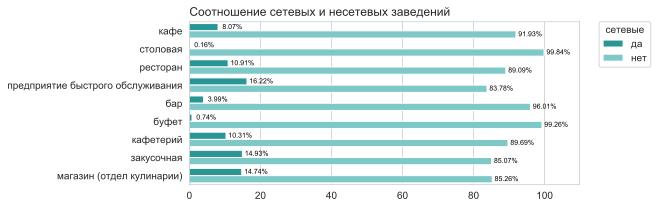

In [27]:
object_type_plot(object_type_unique_chain, '', 'object_type_unique_chain')

Нормализовав значения, мы видим, что сетевых столовых практически нет.  
Достаточно много сетевых фастфудов, но всё равно нет таких видов заведений общественного питания, которые вероятнее окажутся сетевыми.

In [28]:
object_type_chain = object_type_data(rest_data)

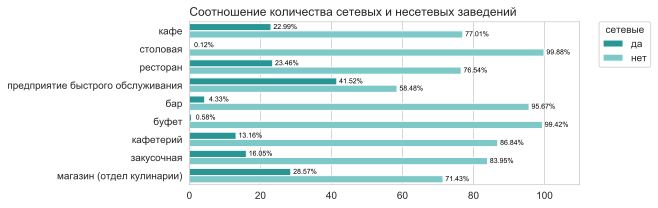

In [29]:
object_type_plot(object_type_chain, 'количества ', 'object_type_chain')

Конечно, у одного сетевого заведения несколько "точек".  
Но теперь стало видно, что у сетевых ресторанов меньше отдельных помещений, чем у сетевых кафе, так же как и у сетевых закусочных по сравнению с отделами кулинарии в магазинах.

<a id="number_seat"></a>
## Количество посадочных мест

In [30]:
rest_chain = rest_data.query('chain == "да"')

In [31]:
rest_chain_group = rest_chain.groupby('object_name_lower').agg({'id':'count','number':'mean'}).reset_index()

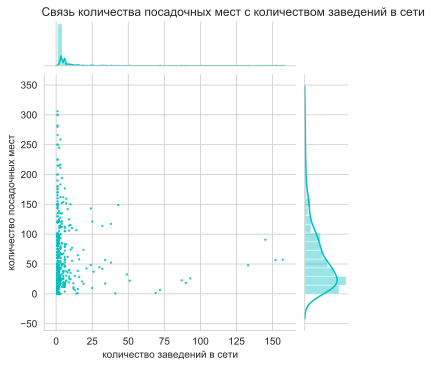

In [32]:
sns.set_style('whitegrid')
sns.jointplot(x = 'id', y = 'number', data = rest_chain_group, kind = 'reg',
                   color = 'c', fit_reg = False, scatter_kws = {"s": 2}, height = 5)
plt.suptitle('Связь количества посадочных мест с количеством заведений в сети', y = 1.01, x = 0.65)
plt.xlabel('количество заведений в сети')
plt.ylabel('количество посадочных мест')
plt.savefig('images/rest_chain_group.png', bbox_inches = 'tight')
plt.show()

Для сетевых заведений характерно иметь не больше 15 помещений, хотя скорее всего такая картина получилась из-за проблем в данных.  
Явно видно, что много помещений в сети имеют меньше посадочных мест, чем сети с меньшим количеством помещений.

In [33]:
object_type_number = pd.DataFrame(rest_data.groupby('object_type').agg('mean')['number'].reset_index())

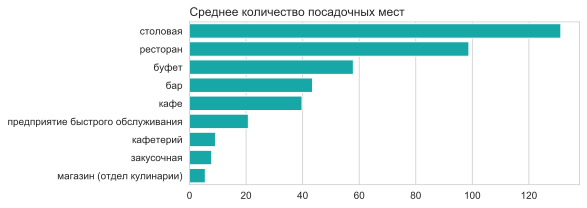

In [34]:
f, ax = plt.subplots(figsize = (7, 3))
sns.set_style('whitegrid')
ax = sns.barplot(x = 'number', y = 'object_type',
                 data = object_type_number.sort_values('number', ascending = False), color = 'c')
ax.set_title('Среднее количество посадочных мест', loc = 'left')
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('images/object_type_number.png', bbox_inches = 'tight')
plt.show()

Конечно, столовые могут принять наибольшее количество людей, ведь в основном столовые находятся в учебных заведениях или на заводах, где нет постоянного потока людей, а большинство из них приходят обедать одновременно.

<a id="location"></a>
## Геолокация

<a id="street"></a>
### Улицы

Для таких адресов как эти: "город Москва, поселение Щаповское, деревня Троицкое, домовладение 66, корпус 2" будем считать, что поселение Щаповское, деревня Троицкое - это, наверное, район, а улицы нет.  
Для адресов вида "город Москва, город Московский..." есть названия улиц, а город Московский можно было бы считать районом.  
А так как в адресе "город Москва, улица Мичуринский Проспект, Олимпийская Деревня" улица Мичуринский Проспект, Олимпийская Деревня является названием улицы, которая находится в районе Фили-Давыдково, то в название улицы надо записать всё, что находится между "город Москва" и "дом..."

Другая ситуация обстоит с Зеленоградом. Дело в том, что Зеленоград изначально задумывался как город будущего, экспериментальный. В зеленоградских адресах как правило нет названия улицы, сразу за словом «Зеленоград» идет трех- или четырехзначный номер корпуса (дома), который состоит из номера микрорайона (одна или две цифры) и двузначного номера дома.  
Тогда логично считать, что улиц там нет.

In [35]:
# находит в адресе улицы, если таких нет, за улицу принимается всё, что не город Москва и не дом/домовладение/корпус
def address_to_street(text):
    type_district = ['город ', 'поселение ', 'село ', 'ж/к', 'деревня ', 'посёлок ',
                     'микрорайон', 'территория']
    type_house = ['дом ', 'домовладение ', 'корпус ', 'владение ', 'строение ']
    address_array = re.split(r', ', text)
    street = ''
    for part_address in address_array:
        flag = 0
        if part_address == 'город Москва':
            continue
        for type_d in type_district:
            if type_d in part_address:
                flag = 1
        for type_h in type_house:
            if type_h in part_address:
                return street
        if flag == 0:
            if street != '':
                street = part_address + ' ' + street
            else:
                street = part_address

In [36]:
rest_data['street'] = rest_data['address'].apply(lambda row: address_to_street(row))

In [37]:
rest_data.sample(3)

,id,object_name,chain,object_type,address,number,object_name_lower,street
4556,23520,МАЙЯ,нет,ресторан,"город Москва, Рязанский проспект, дом 75, строение 1",84,майя,Рязанский проспект
9057,161544,Завтраки,нет,ресторан,"город Москва, Никольская улица, дом 10",20,завтраки,Никольская улица
8688,134633,ПБО «ВокМания»,нет,предприятие быстрого обслуживания,"город Москва, проспект Вернадского, дом 86А",60,пбо «вокмания»,проспект Вернадского


In [38]:
top_street = pd.DataFrame(
    rest_data.query('street != ""').groupby('street').agg('count')
    .sort_values('id', ascending = False)['id'].head(10)
    .reset_index().rename(columns = {'id':'total'})
)

In [39]:
top_street['count_cafe'] = (
    top_street['street'].apply(lambda row: rest_data.query('street == @row and object_type == "кафе"')['id'].count())
)
top_street['count_dining'] = (
    top_street['street'].apply(lambda row: rest_data.query('street == @row and object_type == "столовая"')['id'].count())
)
top_street['count_restaurant'] = (
    top_street['street'].apply(lambda row: rest_data.query('street == @row and object_type == "ресторан"')['id'].count())
)
top_street['count_fastfood'] = (
    top_street['street'].apply(lambda row: rest_data.query('street == @row and object_type ==\
    "предприятие быстрого обслуживания"')['id'].count())
)
top_street['count_bar'] = (
    top_street['street'].apply(lambda row: rest_data.query('street == @row and object_type == "бар"')['id'].count())
)
top_street['count_buffet'] = (
    top_street['street'].apply(lambda row: rest_data.query('street == @row and object_type == "буфет"')['id'].count())
)
top_street['count_cafeteria'] = (
    top_street['street'].apply(lambda row: rest_data.query('street == @row and object_type == "кафетерий"')['id'].count())
)
top_street['count_eatery'] = (
    top_street['street'].apply(lambda row: rest_data.query('street == @row and object_type == "закусочная"')['id'].count())
)
top_street['count_store'] = (
    top_street['street'].apply(lambda row: rest_data.query('street == @row and object_type == \
    "магазин (отдел кулинарии)"')['id'].count())
)

In [40]:
top_street

,street,total,count_cafe,count_dining,count_restaurant,count_fastfood,count_bar,count_buffet,count_cafeteria,count_eatery,count_store
0,проспект Мира,204,103,8,32,26,15,3,5,4,8
1,Ленинградский проспект,172,70,14,48,16,10,5,4,0,5
2,Профсоюзная улица,170,90,15,20,23,5,3,10,2,2
3,Пресненская набережная,167,98,0,40,18,5,1,5,0,0
4,Варшавское шоссе,161,63,25,9,41,6,5,8,2,2
5,Ленинский проспект,147,64,25,37,9,6,2,3,1,0
6,проспект Вернадского,128,55,14,19,24,4,5,3,2,2
7,Кутузовский проспект,113,41,6,47,8,6,1,0,2,2
8,Каширское шоссе,111,30,17,9,42,2,3,8,0,0
9,Кировоградская улица,108,16,14,18,46,4,1,2,4,3


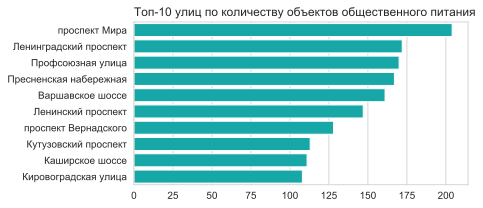

In [41]:
f, ax = plt.subplots(figsize = (6, 3))
sns.set_style('whitegrid')
ax = sns.barplot(x = 'total', y = 'street', color = 'c', data = top_street)
ax.set_title('Топ-10 улиц по количеству объектов общественного питания', loc = 'left')
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('images/top_street_count.png', bbox_inches = 'tight')
plt.show()

In [42]:
top_street_diff = top_street[['street', 'count_cafe', 'count_dining', 'count_restaurant',
                              'count_fastfood', 'count_bar', 'count_buffet', 'count_cafeteria',
                              'count_eatery', 'count_store']].melt('street')
type_dict = {'count_cafe':'кафе', 'count_dining':'столовая', 'count_restaurant':'ресторан',
             'count_fastfood':'предприятие быстрого обслуживания', 'count_bar':'бар',
             'count_buffet':'буфет', 'count_cafeteria':'кафетерий', 'count_eatery':'закусочная',
             'count_store':'магазин (отдел кулинарии)'}
top_street_diff['variable'] = top_street_diff['variable'].map(type_dict)

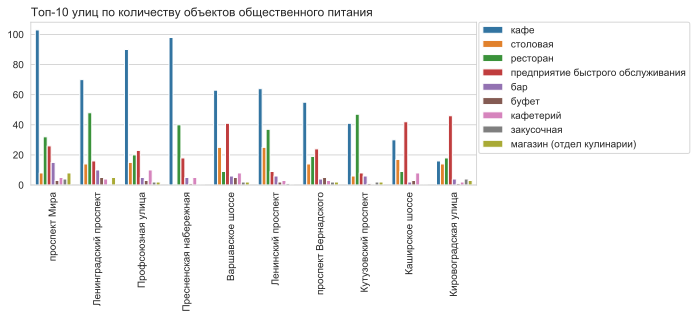

In [43]:
f, ax = plt.subplots(figsize = (8, 3))
sns.set_style('whitegrid')
ax = sns.barplot(x = 'street', y = 'value', hue = 'variable', data = top_street_diff)
ax.set_title('Топ-10 улиц по количеству объектов общественного питания', loc = 'left')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(bbox_to_anchor = (1.005, 1), loc = 2, borderaxespad = 0)
plt.savefig('images/top_street_count_type.png', bbox_inches = 'tight')
plt.show()

В основном "попасть в топ" улицам помогают многочисленные кафе. Но на Кутузовском проспекте больше всего ресторанов, а на Каширском шоссе и Кировоградской улице - фастфудов.  
Возможно, это связано с тем, что Кутузовский проспект частично находится в пределах ТТК, в то время как Каширское шоссе и Кировоградская - на окраине города.

<a id="district"></a>
### Районы

Возьмём данные о принадлежности улицы к какому-либо району с сайта `http://mosopen.ru/streets`

In [44]:
street_district = pd.DataFrame(columns = ['street', 'district'])
response = requests.get('http://mosopen.ru/streets')
soup = BeautifulSoup(response.text)
district_dict = {}
for link in soup.find_all('a'):
    if link['href'].find('http://mosopen.ru/region/') != -1:
        district_dict[link.text] = link['href']
i = 0
for name in district_dict:
    response = requests.get(district_dict[name])
    soup = BeautifulSoup(response.text)
    for alink in soup.find_all('a'):
        if alink['href'].find('http://mosopen.ru/street/') != -1:
            street_name = alink.text
            arr_street_name = re.split(r', ', street_name)
            if len(arr_street_name) > 1:
                street_name = arr_street_name[1] + ' ' + arr_street_name[0]
            street_district.loc[i, 'district'] = name
            street_district.loc[i, 'street'] = street_name
            i += 1

In [45]:
street_district.sample(3)

,street,district
3101,Стромынский переулок,Сокольники
1729,улица Панфёрова,Ломоносовский
2362,улица Дубовой Рощи,Останкинский


In [46]:
def street_to_district(text):
    dist = street_district.query('street == @text')['district'].values
    if len(dist) != 0:
        return dist[0]

<a id="top_location"></a>
#### Популярные районы и улицы

In [47]:
top_street['district'] = top_street['street'].apply(lambda row: street_to_district(row))

In [48]:
top_street[['street', 'district']]

,street,district
0,проспект Мира,Алексеевский
1,Ленинградский проспект,Аэропорт
2,Профсоюзная улица,Академический
3,Пресненская набережная,Пресненский
4,Варшавское шоссе,Бутово Северное
5,Ленинский проспект,Гагаринский
6,проспект Вернадского,Гагаринский
7,Кутузовский проспект,Дорогомилово
8,Каширское шоссе,Москворечье-Сабурово
9,Кировоградская улица,Чертаново Северное


В Гагаринском районе целых 2 крупных улицы "насыщенных" заведенями общественного питания. Возможно, это связано с тем, что в этом районе находится несколько ВУЗов: студентов много и они любят после пар посидеть где-нибудь. Или вместо пар =)  
Здесь может возникнуть парадокс: если посмотреть на все данные, а не только на самые популярные улицы, возможно, Гагаринский район не будет самым "насыщенным".

In [49]:
top_street_array = top_street['street'].unique()

In [50]:
top_street_rest = rest_data.query('street in @top_street_array')

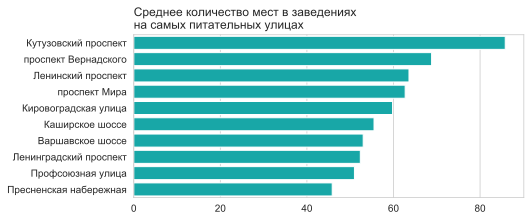

In [51]:
f, ax = plt.subplots(figsize = (7, 3))
sns.set_style('whitegrid')
ax = sns.barplot(x = 'number', y = 'street',
                 data = top_street_rest.groupby('street')['number'].mean()
                 .reset_index().sort_values('number', ascending = False), color = 'c')
ax.set_title('Среднее количество мест в заведениях\nна самых питательных улицах', loc = 'left')
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('images/top_street_rest.png', bbox_inches = 'tight')
plt.show()

В заведениях на Кутузовском проспекте больше всего посадочных мест. Возможно, из-за того, что там преобладают рестораны.

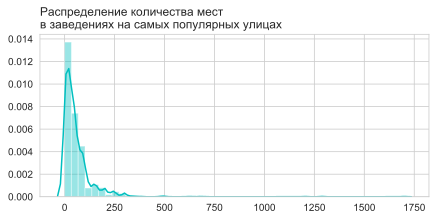

In [52]:
f, ax = plt.subplots(figsize = (7, 3))
sns.set_style('whitegrid')
ax = sns.distplot(top_street_rest['number'], color = 'c')
ax.set_title('Распределение количества мест\nв заведениях на самых популярных улицах', loc = 'left')
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('images/top_street_rest_number.png', bbox_inches = 'tight')
plt.show()

Чаще встречаются заведения с небольшим количеством посадочных мест, ведь для расположения меньшего количества людей нужна меньшая площадь арендуемого помещения.

<a id="tail_location"></a>
#### Не популярные районы и улицы

Теперь нужно определить район для всех улиц.  
С нашим алгоритмом возникнут проблемы:  
- с улицами, которые записаны не в том порядке, например "1-й Балтийский переулок" не найдётся как "переулок Балтийский 1-й"
- с улицей "Олимпийская Деревня улица Мичуринский Проспект"
- с улицами из поселений и городов внутри Москвы

Для улиц с номерами можно изменить порядок слов в названии на противоположный, но тогда страдают улицы 8 Марта и, наверное, не только они.  
Мичуринский проспект нужно будет переписывать "руками", как и улицу 26-ти Бакинских Комиссаров, а районы из поселений и городов по базе с сайта http://mosopen.ru/streets всё равно не определятся. Поэтому оставшиеся районы определим, взяв таблицу с сайта https://data.mos.ru/opendata/7710881420-obshchestvennoe-pitanie-v-moskve. Хотя по-моему это чит.

In [53]:
rest_data_district = pd.read_excel('../datasets/data-4275-2019-10-07.xlsx', index_col = 0)

In [54]:
# сразу удалим все ненужные нам столбцы
rest_data_district = rest_data_district.reset_index()[['District', 'Address']]

In [55]:
address_district_dict = pd.Series(rest_data_district.District.values, index = rest_data_district.Address).to_dict()
rest_data['district'] = rest_data['address'].map(address_district_dict)

In [56]:
rest_data.sample(3)

,id,object_name,chain,object_type,address,number,object_name_lower,street,district
4182,29300,"Строительный колледж № 26, СП 2",нет,столовая,"город Москва, 5-я Кожуховская улица, дом 26, строение 1",120,"строительный колледж № 26, сп 2",5-я Кожуховская улица,Южнопортовый район
4024,29043,ШКОЛА №1466 ОАО «КДП»,нет,столовая,"город Москва, Ереванская улица, дом 18, корпус 1",240,школа №1466 оао «кдп»,Ереванская улица,район Царицыно
13556,214426,Le Bar A Vin,нет,бар,"город Москва, Краснопролетарская улица, дом 8, строение 1",45,le bar a vin,Краснопролетарская улица,Тверской район


In [57]:
anti_top_street = pd.DataFrame(
    rest_data.query('street != ""').groupby('street').agg({'id':'count', 'district':'max'})
    .sort_values('id')[['id', 'district']]
    .reset_index().rename(columns = {'id':'total'}).query('total == 1')
)

In [58]:
print ('Количество улиц с одним объектом общественного питания:', anti_top_street.shape[0])

Количество улиц с одним объектом общественного питания: 579


In [59]:
not_anti_top_street = pd.DataFrame(
    rest_data.query('street != ""').groupby('street').agg({'id':'count', 'district':'max'})
    .sort_values('id')[['id', 'district']]
    .reset_index().rename(columns = {'id':'total'}).query('total > 1')
)

In [60]:
district_not_eat = anti_top_street['district'].unique()
for dist in district_not_eat:
    if dist in not_anti_top_street['district'].unique():
        district_not_eat = np.delete(district_not_eat, np.where(district_not_eat == dist))
print (district_not_eat)

['поселение Кленовское' 'поселение Новофедоровское'
 'поселение Вороновское' 'поселение Киевский' 'поселение Краснопахорское'
 'поселение Рязановское']


Существует примерно 580 улиц, на которых находится только одно заведение общественного питания. Они находятся в разных районах, и, наверное, в каждом районе есть улица, на которой почти негде поесть, но если оставить только те районы, где ни на одной улице нет более одного заведения общественного питания, то остаются только поселения, то есть в пределах МКАД таких точно нет. Причем все они находятся на юго-западе, примерно рядом с Троицком и Наро-Фоминском.

Открывать своё кафе с роботами в ближайшем Подмосковье мы точно не будем, поэтому рассмотрим всё-таки районы Москвы в пределах МКАД, где встречаются улицы с 1 заведением общественного питания и определим эти улицы.

In [61]:
district_not_eat = anti_top_street['district'].unique()
new_district_not_eat = {}
for i in range(len(district_not_eat)):
    dist_arr = re.split(r' ', district_not_eat[i])
    temp = ''
    for word in dist_arr:
        if word == 'район':
            continue
        else:
            if temp == '':
                temp = word
            else:
                temp += word
    new_district_not_eat[district_not_eat[i]] = temp
        
district = street_district['district'].unique()
new_district_not_eat_in_msk = {}
for key, value in new_district_not_eat.items():
    if value in district:
        new_district_not_eat_in_msk[key] = value

In [62]:
print ('Улицы в Москве, на которых находится не больше 1 заведения общественного питания:\n',
       anti_top_street.query('district in @new_district_not_eat_in_msk.keys()')['street'].unique())

Улицы в Москве, на которых находится не больше 1 заведения общественного питания:
 ['Кондрашёвский тупик' 'Дегтярный переулок' 'проезд Нансена'
 'Делегатская улица' 'Денежный переулок' 'Скатертный переулок'
 'Дивизионная улица' 'Дмитровский переулок' 'Добровольческая улица'
 'Докучаев переулок' 'Симферопольский проезд' 'Сивашская улица'
 'улица Маршала Новикова' 'улица Маршала Мерецкова' 'Сибирский проезд'
 'Сеченовский переулок' 'Егорьевский проезд' 'Скорняжный переулок'
 'Елоховский проезд' 'Гродненская улица' 'Гранатный переулок'
 'Газгольдерная улица' 'Гвардейская улица' 'Гжатская улица'
 'Гжельский переулок' 'Глазовский переулок' 'Глебовская улица'
 'Глинистый переулок' 'Глинищевский переулок' 'улица Медиков'
 'улица Медведева' 'Гольяновская улица' 'Гончарная набережная'
 'Соймоновский проезд' 'Госпитальный переулок' 'Есенинский бульвар'
 'проезд Черепановых' 'Живарев переулок' 'Садовнический проезд'
 'Интернациональная улица' 'улица Линии Октябрьской Железной Дороги'
 'улица Лефо

Теперь, когда определены все районы, вернёмся к вопросу о самых популярных районах.

In [63]:
top_district = rest_data.groupby(['district'])['id'].agg('count').reset_index().sort_values('id', ascending = False)

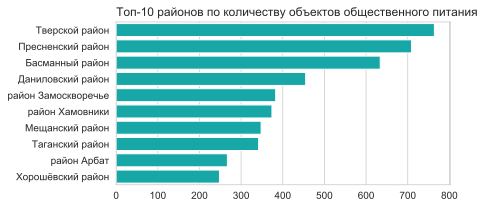

In [64]:
f, ax = plt.subplots(figsize = (6, 3))
sns.set_style('whitegrid')
ax = sns.barplot(x = 'id', y = 'district', color = 'c', data = top_district.head(10))
ax.set_title('Топ-10 районов по количеству объектов общественного питания', loc = 'left')
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('images/top_district_count.png', bbox_inches = 'tight')
plt.show()

<a id="summary"></a>
# **Выводы**

**1. Проблемы в данных**  
- Встречаются дубликаты с разными id.
- Названия заведений записаны в разных форматах, где-то по-русски, где-то по-английски, где-то транслитом.
- Существуют заведения с очень похожими названиями одного и того же вида, расположенные по одному и тому же адресу, но имеющие разное количество посадочных мест.
- Существуют заведения с одинаковыми названиями, но определённые как не сетевые.
- Для 10.4% заведений указано 0 посадочных мест.  
Всё это сильно искажает исследование: невозможно посчитать реальное количество уникальных заведений, невозможно точно определить какие заведения сетевые, а какие нет, и соответственно сравнить эти группы, невозможно анализировать количество посадочных мест.

**2. Исследование и предобработка данных**  
- Дубликаты с разными id были удалены.
- Названия заведений остались без обработки, поскольку сделать это оптимально не представляется возможным.
- 0.83% столовых, ресторанов и буфетов без посадочных мест удалены.
- Для выделения названия улицы из адреса принято считать, что всё между двух запятых или в начале строки адреса, где нет слов 'город ', 'поселение ', 'село ', 'ж/к', 'деревня ', 'посёлок ', 'микрорайон', 'территория', 'дом', 'домовладение', 'корпус', 'владение', 'строение', это название улицы. 
- Для определения района, на которой находится улица, информация взята с сайта [Электронная Москва. Улицы Москвы](http://mosopen.ru/streets). Этот сайт не дал информации о районах таких частей Москвы, как, например, город Московский, поэтому принадлежность к районам была переопределена с помощью таблицы, взятой с сайта [Портал открытых данных Правительства Москвы](https://data.mos.ru/opendata/7710881420-obshchestvennoe-pitanie-v-moskve)  

**3. Анализ данных**  

***Виды объектов общественного питания***  
Из всех видов заведений общественного питания кафе больше всего:
![](images/object_type_count.png)
Возможно, кафе наиболее распространены, поскольку этим словом именуются заведения очень разного уровня. Как правило в их ассортименте могут быть полуфабрикаты быстрого приготовления, традиционная национальная кухня, недорогие закуски и напитки, а замысловатых блюд, требующих долгого приготовления тут нет. К тому же кафе рассчитаны на широкую аудиторию: сюда ходят школьники и студенты, семьи с детьми, взрослые люди.  
Сетевых столовых и буфетов практически нет, зато достаточно много сетевых фастфудов:
![](images/object_type_chain.png)
Предприятия быстрого обслуживания за счёт скорости приготовления и специфичности предлагаемых блюд (в основном это что-то питательное и быстропотребляемое) могут иметь большее количество посетителей с меньшим набором персонала. К тому же часто фастфуды это просто окошко выдачи заказа с парой столиков, что позволяет экономить на аренде помещения и открывать несколько точек по всему городу.  

***Количество посадочных мест***  
Для сетевых заведений характерно иметь не больше 15 помещений, хотя скорее всего такая картина получилась из-за проблем в данных.  
Явно видно, что много помещений в сети имеют меньше посадочных мест, чем сети с меньшим количеством помещений.
![](images/rest_chain_group.png)
Проще уместить лишний стол, чем открыть дополнительное помещение.  
Конечно, столовые могут принять наибольшее количество людей, ведь в основном столовые находятся в учебных заведениях или на заводах, где нет постоянного потока людей, а большинство из них приходят обедать одновременно.
![](images/object_type_number.png)
В столовых часто принято самообслуживание, что позволяет принимать много людей без трат на официантов.  

***Популярные места в городе***
![](images/top_street_count.png)
![](images/top_street_count_type.png)
Чаще всего встречаются кафе, хотя на Каширском шоссе и Кировоградской улице больше предприятий быстрого обслуживания, а на Кутузовском проспекте - ресторанов.  
Эти улицы находятся в самых разных районах:

улица|район
-|-
проспект Мира|Алексеевский
Ленинградский проспект|Аэропорт
Профсоюзная улица|Академический
Пресненская набережная|Пресненский
Варшавское шоссе|Бутово Северное
Ленинский проспект|Гагаринский
проспект Вернадского|Гагаринский
Кутузовский проспект|Дорогомилово
Каширское шоссе|Москворечье-Сабурово
Кировоградская улица|Чертаново Северное

В Гагаринском районе целых 2 крупных улицы "насыщенных" заведенями общественного питания. Возможно, это связано с тем, что в этом районе находится несколько ВУЗов: студентов много и они любят после пар посидеть где-нибудь.  
Здесь тоже чаще встречаются заведения с небольшим количеством посадочных мест
![](images/top_street_rest_number.png)

Однако самый популярный район - Тверской:
![](images/top_district_count.png)
В этом районе находится самая оживлённая в Москве улица - Тверская. Логично открывать заведения общественного питания там, где каждый день проходит большое количество людей.  

Существуют улицы, на которых находится не больше одного заведения общественного питания. Интересно посмотреть на них повнимательнее, возможно, изучить поток людей в этих местах в разное время суток и в разное время года, а также узнать, планируются ли там какие-либо постройки, например, школы или нового кинотеатра, так как на этих улицах будет меньше конкуренция.

Презентация: [Анализ заведений общественного питания в Москве.pdf](https://yadi.sk/i/Bbjj5dwXirF04A)